In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import classification as clf
import imbalanced as imb
from sklearn.model_selection import KFold 
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import statistics
data = clf.load_data("data_for_student_case.csv")
from sklearn import tree

In [2]:
pdata = clf.pre_process(data)
clf.describe_data(pdata)

pdata.head()

Total: 237036
Non-Fraud: 236691 = 99.8545%
Fraud: 345 = 0.1455%



,issuercountrycode,txvariantcode,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,76.0,2.0,64800.0,2.0,98.0,0.0,1.0,0.0,1.0,187702.0,7386.0,73358.0
1,76.0,2.0,44900.0,2.0,98.0,0.0,1.0,0.0,1.0,834.0,194109.0,44739.0
2,76.0,2.0,149900.0,2.0,98.0,0.0,1.0,0.0,1.0,119287.0,189655.0,122802.0
3,76.0,2.0,109900.0,2.0,98.0,0.0,1.0,0.0,1.0,173561.0,8254.0,70712.0
4,76.0,6.0,89900.0,2.0,98.0,0.0,1.0,0.0,1.0,70647.0,196247.0,208481.0


Total: 237036
Non-Fraud: 236691 = 99.8545%
Fraud: 345 = 0.1455%

Mean false positive rate (white): 0.0
Mean false positive rate (black): 0.686803720237181
Mean true positives (white): 34.4
Mean true positives (black): 23.9
Mean false positives (white): 0.1
Mean false positives (black): 10.6


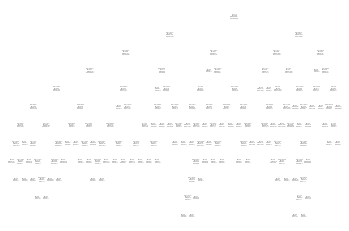

In [3]:
pdata = imb.pre_process(data)
imb.describe_data(pdata)

# Get feature vector and truth vector from dataset
X, y = imb.get_X_y(pdata)

splits = 10
cv = KFold(n_splits=splits, shuffle=True)
scores_whitebox = np.zeros(10)
scores_blackbox = np.zeros(10)
false_negatives_white = np.zeros(10)
false_negatives_black = np.zeros(10)
true_positives_white = np.zeros(10)
true_positives_black = np.zeros(10)

iteration = 0
for train_index, test_index in cv.split(X):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # SMOTE Re-sampling
    sm = SMOTE()
    X_train, y_train = sm.fit_sample(X_train, y_train)

    # Classifiers
    # Decision Tree classifer (White-Box)
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    tree.plot_tree(clf.fit(X_test, y_test)) 
    y_pred = clf.predict(X_test)
#     tree.plot_tree(clf.fit(iris.data, iris.target)) 
    CM = confusion_matrix(y_test, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    true_positives_white[iteration] = TP
    false_negatives_white[iteration] = FN
    false_positve_rate = FP / (FP + TN)
    scores_whitebox[iteration] = false_positve_rate

    # Neural network model (Black-box)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(5, 2))
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    CM = confusion_matrix(y_test, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    true_positives_black[iteration] = TP
    false_negatives_black[iteration] = FN
    false_positve_rate = FP / (FP + TN)
    scores_blackbox[iteration] = false_positve_rate
    iteration += 1 
print("Mean false positive rate (white): " + str(np.mean(scores_whitebox)))
print("Mean false positive rate (black): " + str(np.mean(scores_blackbox)))
print("Mean true positives (white): " + str(np.mean(true_positives_white)))
print("Mean true positives (black): " + str(np.mean(true_positives_black)))
print("Mean false positives (white): " + str(np.mean(false_negatives_white)))
print("Mean false positives (black): " + str(np.mean(false_negatives_black)))


# clf.classify_knn(pdata,25)